## Parametric Correlations

Answers to exercises found here: 

https://canvas.upenn.edu/courses/1358934/discussion_topics/5600885

NOTE: Be sure to run the cells in order!!!

Dependencies: statsmodels (https://www.statsmodels.org/stable/index.html)

Copyright 2019 by Yale E. Cohen, University of Pennsylvania

Updated 01/01/20 by jig

Converted to Python 03/28/21 by jig

In [ ]:
import platform

# Output on system used for development/testing:
# 3.9.2
print(platform.python_version())

# Uncomment and run to clear workspace
# %reset

Text(0, 0.5, 'Wing Length (cm)')

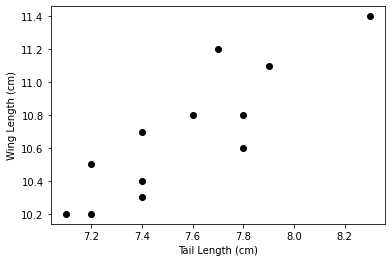

In [1]:
import matplotlib.pyplot as plt

# Always run this cell to load the data
wing_length = [10.4, 10.8, 11.1, 10.2, 10.3, 10.2, 10.7, 10.5, 10.8, 11.2, 10.6, 11.4]
tail_length = [7.4, 7.6, 7.9, 7.2 ,7.4, 7.1, 7.4, 7.2, 7.8, 7.7, 7.8, 8.3]

# Plot the data
plt.plot(tail_length, wing_length, 'ko')
plt.xlabel('Tail Length (cm)')
plt.ylabel('Wing Length (cm)')


In [7]:

import numpy as np

# Compute r
# 1. Compute by hand
n             = np.size(wing_length)
sample_mean_x = np.sum(wing_length)/n
sample_mean_y = np.sum(tail_length)/n
SSEX          = np.sum((wing_length - sample_mean_x) ** 2)
SSEY          = np.sum((tail_length - sample_mean_y) ** 2)
SCOVXY        = np.sum((wing_length - sample_mean_x)*(tail_length - sample_mean_y))
rXY           = SCOVXY/(np.sqrt(SSEX)*np.sqrt(SSEY))
rYX           = SCOVXY/(np.sqrt(SSEY)*np.sqrt(SSEX))

# Use corrcoef
r_builtin = np.corrcoef(wing_length, tail_length)

# Show that they are all the same
print(f'rXY={rXY:.4f} (computed), {r_builtin[0,1]:.4f} (built-in)')
print(f'rYX={rYX:.4f} (computed), {r_builtin[1,0]:.4f} (built-in)')

rXY=0.8704 (computed), 0.8704 (built-in)
rXY=0.8704 (computed), 0.8704 (built-in)


In [24]:
import scipy.stats as st

# Compute standard error/confidence intervals, using the formulas in the Canvas discussion

# Compute standard error directly 
standard_error_r = np.sqrt((1-rXY**2)/(n-2))

# Compute confidence intervals *of the full distribution* by: 
# 1. using Fisher's z-tranformation to make a variable that is normally distributed
z = 0.5*np.log((1+rXY)/(1-rXY))

# 2. Compute the standard deviation of z
z_std = np.sqrt(1/(n-3))

# 3. Get the 95% CIs of the transformed variable from the std
scale = st.norm.ppf(0.025)*z_std
z_95CIs = np.array([z+scale, z-scale])

# 4. Convert back to r (inverse z-transformation)
CI95 = (np.exp(2*z_95CIs)-1)/(np.exp(2*z_95CIs)+1)
# Show it
print(f'r={rXY:.2f}, sem={standard_error_r:.4f}, 95 pct CI = [{CI95[0]:.4f}, {CI95[1]:.4f}]')


r=0.87, sem=0.1557, 95 pct CI = [0.5923, 0.9632]


In [27]:
# Compute p-value for H0:r=0
# Two-tailed test
# Remember that the *mean* of r follows a Student's t distribution with two degrees of freedom

# First compute the t-statistic, which is the sample r divided by the sample standard error
t_val = rXY/standard_error_r

# Now compute the p-value. We want the probabily of getting a value of the test statistic that is *at least as large* as the one that we actually measured from our sample (i.e., tVal), given the null distribution. Here we define the null distribution as the t distribution  with n-2 degrees of freedom (recall that the t-distribution for a "regular" t-test has n-1 degrees of freedom... here it's n-2 because we have two samples, X and Y). Because we are using a two-tailed test, this p-value is equal to twice the area under the null t distribution that is greater than tVal. The cumulative distribution is the area that is less than a particular value, so we want 1-cdf
prob = 2*(1-st.t.cdf(t_val,n-2))

# Print it nicely
print(f'p={prob:.4f} for H0: r=0')

p=0.0002 for H0: r=0


In [29]:
# Is this r value different than r=0.75? 
# Here we use a z-test on the z-transformed values, as described in the Canvas discussion

# z-transform the new referent
z_Yale = 0.5*np.log((1+0.75)/(1-0.75))

# Compute the text statistic as the difference in z-transformed values, divided by the sample standard deviation
plambda = (z-z_Yale)/z_std

# Get a p-value from a two-tailed test
prob2 = 2*(1-st.norm.cdf(plambda))
print(f'p={prob2:.4f} for H0: r=0.75')


p=0.2780 for H0: r=0.75


In [36]:
import statsmodels.stats as sm

# Estimate power: That is, p(reject H0|H1 is true)

# Compute the test statistic as above
r_ref   = 0.5;  
z_ref   = 0.5*np.log((1+r_ref)/(1-r_ref))
plambda = (z-z_ref)/np.sqrt(1/(n-3))

# Set a criterion based on alpha
alpha = 0.05
z_criterion = st.norm.ppf(1-alpha/2)

# Power is proportion of expected sample distribution to the right of the criterion
power = 1-st.norm.cdf(z_criterion-plambda)

# Calculate the n needed to ensure that H0 (r=0) is rejected 99% of the time when |r|>= 0.5 at a 0.05 level of significance
#
# Derivation:
#   power = 1-normcdf(z_criterion-lambda)
#   1 - power = normcdf(z_criterion-lambda)
#   zCriterion-lambda = norminv(1 - power)
#   plambda  = z_criterion - norminv(1 - power)
#   (z-z_ref)/sqrt(1/(n-3)) = z_criterion - norminv(1 - power)
#   sqrt(1/(n-3)) = (z-z_ref) / (z_criterion - norminv(1 - power))
#   n = 1/((z-z_ref) / (z_criterion - norminv(1 - power)))^2+3
desired_power = 0.99
predicted_n = np.ceil(1/((z-z_ref) / (z_criterion - st.norm.ppf(1-desired_power)))**2+3)

print(f'power = {power:.4f}, predicted n = {int(predicted_n)}')


power = 0.6539, predicted n = 33
